In [17]:
import astropy.units as u
from astroquery.xmatch import XMatch
from astropy.table import Column,QTable
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astroquery.xmatch import XMatch
import numpy as np
import pandas as pd
from astropy.io import ascii

coord = SkyCoord("04:30:47.99", "+64:50:56.5", unit=(u.hourangle, u.deg), frame='icrs')
rad = 10 * u.arcminute

catalogs = ['vizier:I/345/gaia2', 'vizier:II/246/out', 'vizier:II/328/allwise', 'vizier:II/349/ps1']

data = pd.DataFrame()
df_gaia = QTable(names=('RA_ICRS','DE_ICRS'))
data_2mass = QTable()
data_wise = QTable()
data_panstarrs = QTable()

df_gaia = QTable(names=('RA_ICRS', 'DE_ICRS', 'Gmag'))
df_2mass = QTable()
df_wise = QTable()
df_panstarrs = QTable()

result_table = Vizier.query_region(coord, radius=rad, catalog='I/345/gaia2')
df_gaia = result_table[0]['RA_ICRS','DE_ICRS', 'Gmag', 'e_Gmag']

data_2mass = XMatch.query(cat1=df_gaia,
                     cat2=catalogs[1],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

data_wise = XMatch.query(cat1=data_2mass,
                     cat2=catalogs[2],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

data_panstarrs = XMatch.query(cat1=data_wise,
                     cat2=catalogs[3],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

mag = [['Gmag', 'e_Gmag'], ['Jmag_2', 'e_Jmag_2'],['Hmag_2', 'e_Hmag_2'], ['Kmag_2', 'e_Kmag_2'],
       ['W1mag', 'e_W1mag'], ['W2mag', 'e_W2mag'], ['W3mag', 'e_W3mag'], ['W4mag', 'e_W4mag'],
       ['gmag', 'e_gmag'], ['rmag', 'e_rmag'], ['imag', 'e_imag'], ['zmag', 'e_zmag'], ['ymag', 'e_ymag']]

name = [['G_flux', 'e_G_flux', 'G_wl'],
         ['J_flux', 'e_J_flux', 'J_wl'],
         ['H_flux', 'e_H_flux', 'H_wl'],
         ['K_flux', 'e_K_flux', 'K_wl'],
         ['W1_flux', 'e_W1_flux', 'W1_wl'],
         ['W2_flux', 'e_W2_flux', 'W2_wl'],
         ['W3_flux', 'e_W3_flux', 'W3_wl'],
         ['W4_flux', 'e_W4_flux', 'W4_wl'],
         ['g_flux', 'e_g_flux', 'g_wl'],
         ['r_flux', 'e_r_flux', 'r_wl'],
         ['i_flux', 'e_i_flux', 'i_wl'],
         ['z_flux', 'e_z_flux', 'z_wl'],
         ['y_flux', 'e_y_flux', 'y_wl']]

ZP = np.array([3229, 1594, 1024, 666.7, 309.54, 171.79, 31.676, 8.3635, 3964.03, 3173.02, 2575.36, 2261.81, 2180.4])
wl = np.array([622, 1235, 1662, 2159, 3368, 4618, 12082, 22194, 481, 617, 752, 866, 962]) #cm


data['RA_ICRS'] = data_panstarrs['RA_ICRS']
data['DE_ICRS'] = data_panstarrs['DE_ICRS']

for i in range(len(ZP)):
    for j in range(2):
        data[mag[i][j]] = data_panstarrs[mag[i][j]]
data.fillna(0., inplace=True)

for i in range(len(name)):
    data[name[i][0]] = ZP[i]*10**(-0.4*data[mag[i][0]]) # Jy
    data[name[i][1]] = data[mag[i][1]]*0.4*ZP[i]*10**(-0.4*data[mag[i][0]])*np.log(10) # Jy
    data[name[i][2]] = wl[i]*len(ZP) # cm

data = data.drop(columns=['Gmag', 'e_Gmag', 'Jmag_2', 'e_Jmag_2','Hmag_2', 'e_Hmag_2', 'Kmag_2', 'e_Kmag_2',
       'W1mag', 'e_W1mag', 'W2mag', 'e_W2mag', 'W3mag', 'e_W3mag', 'W4mag', 'e_W4mag',
       'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'ymag', 'e_ymag'])

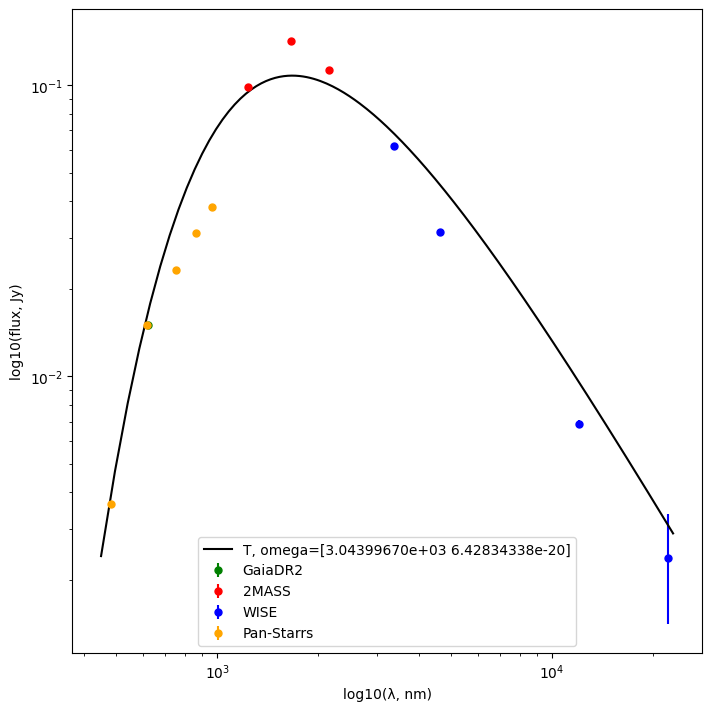

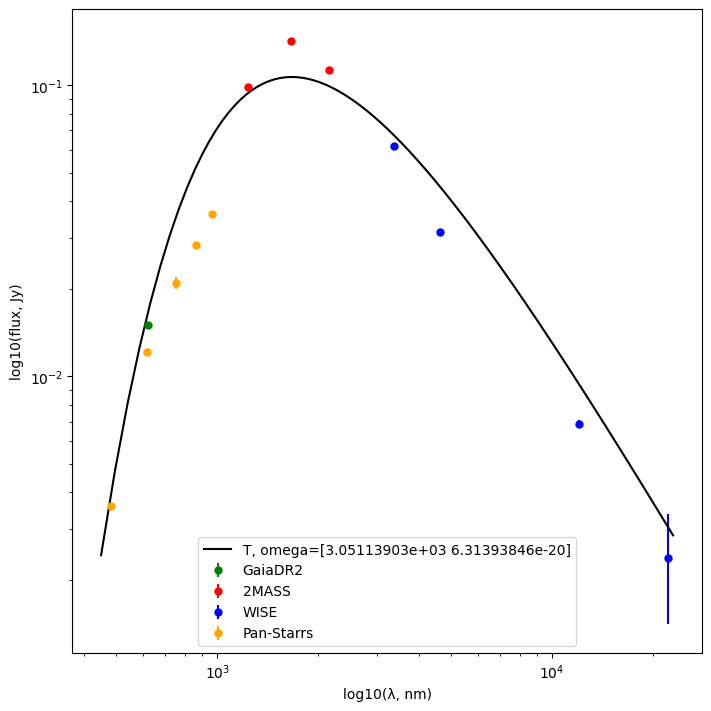

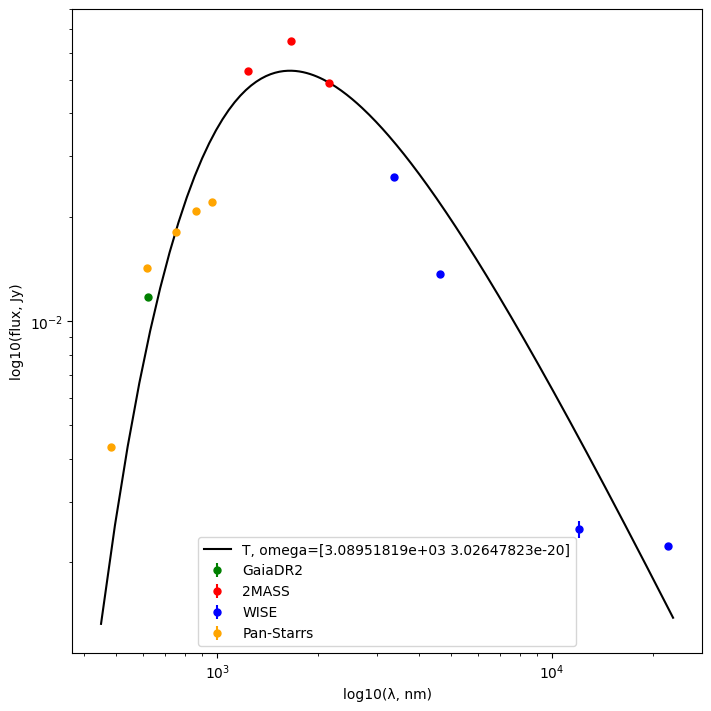

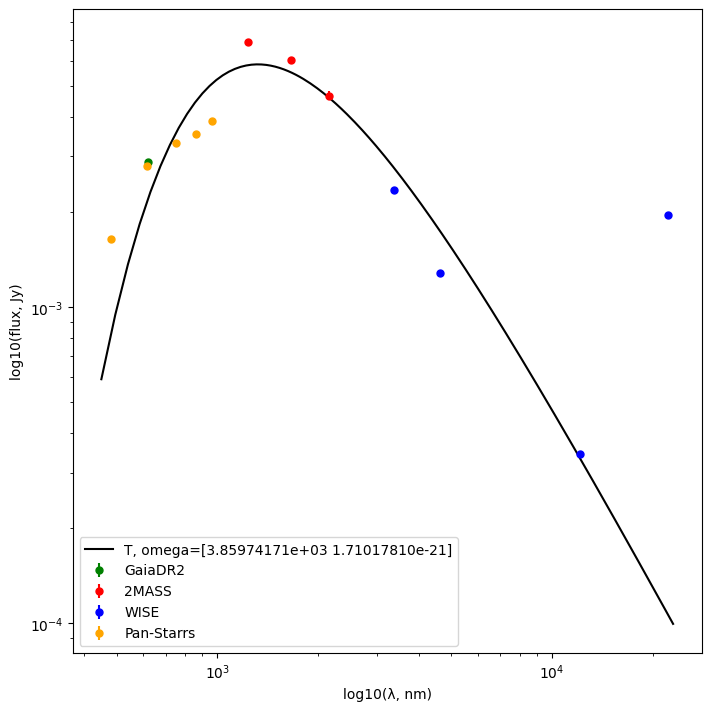

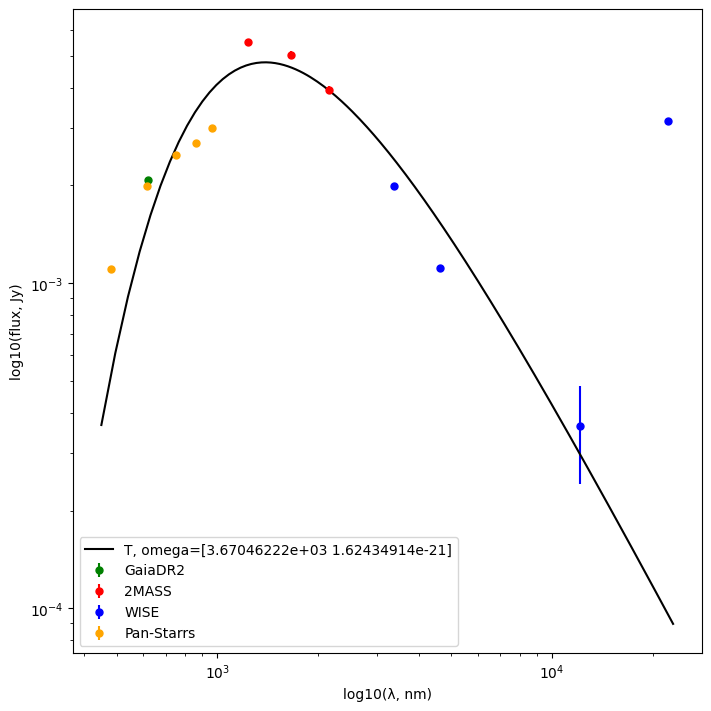

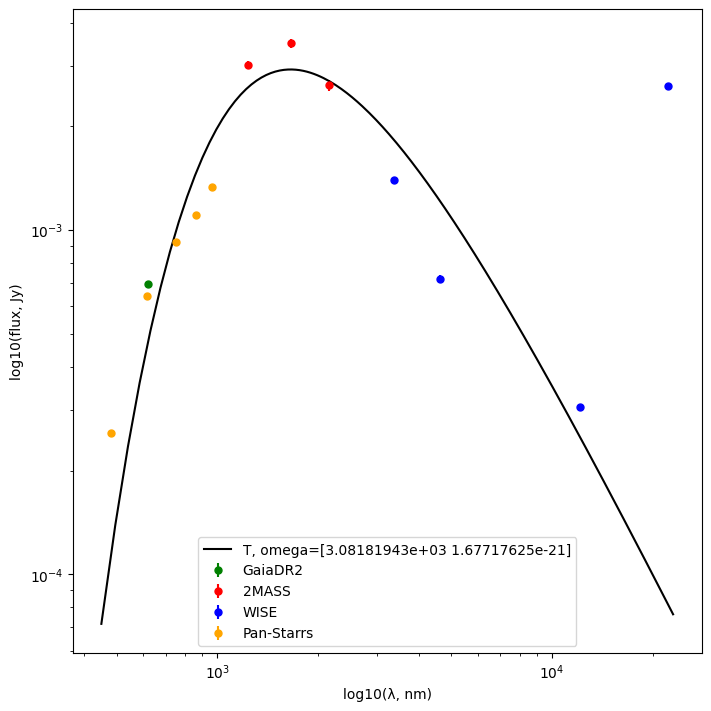

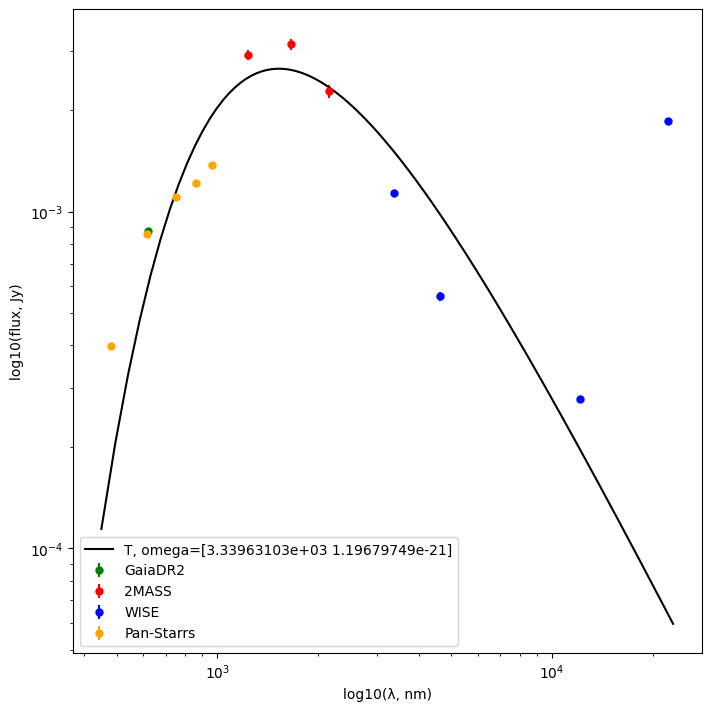

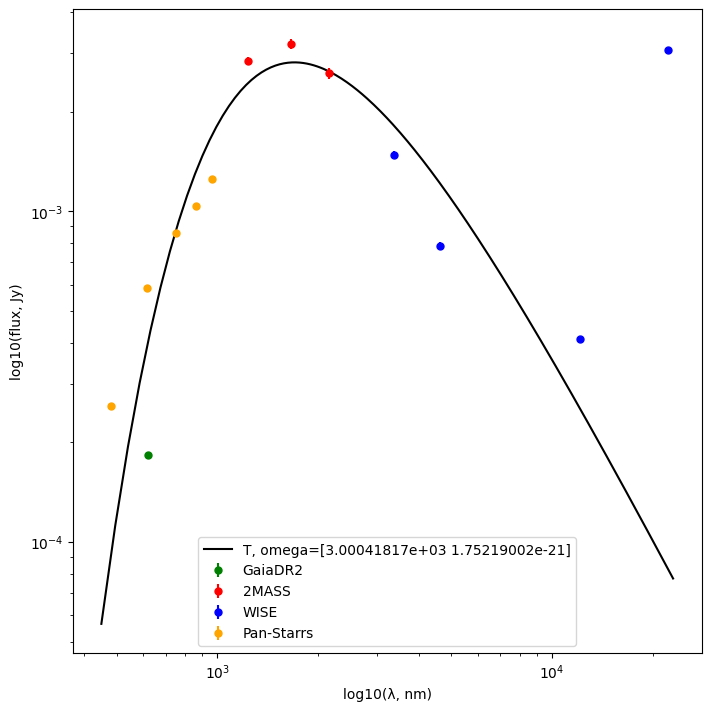

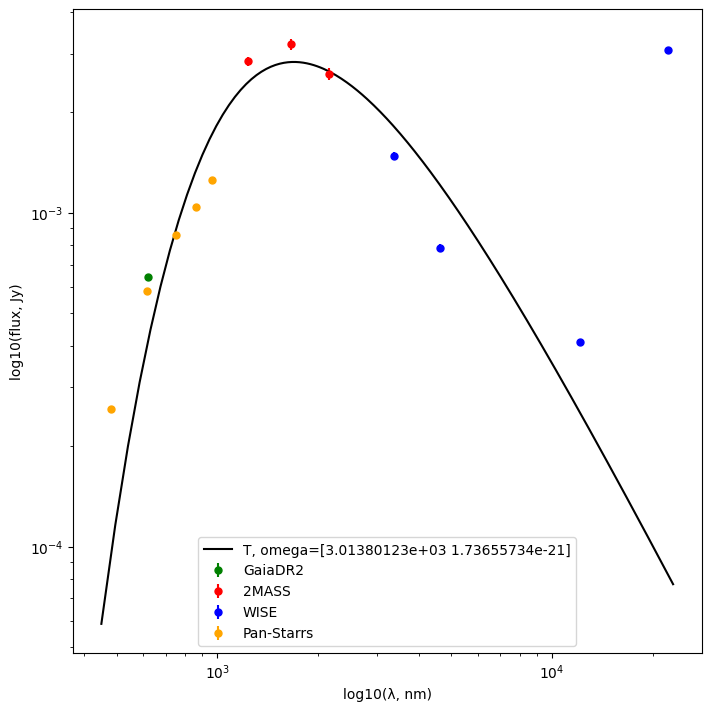

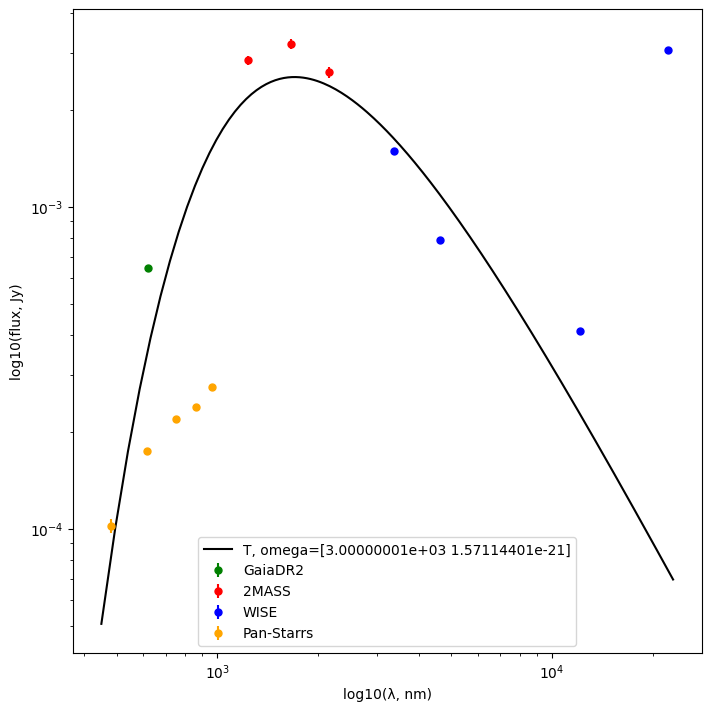

In [18]:
from scipy.optimize import curve_fit
from astropy.modeling import models


def Planck(wl, T, omega):
    b = models.BlackBody(temperature=T*u.K)
    f = b(wl*u.nm).to(u.Jy/u.sr) * np.pi *u.sr * omega
    return f.value

data = data.sort_values(by=['J_flux'], ascending=False)
data = data.reset_index(drop=True)

for i in range(10):
    flux = [data[name[j][0]][i] for j in range(len(wl))]
    flux_error = [data[name[j][1]][i] for j in range(len(wl))]
    popt, pcov = curve_fit(Planck, wl, flux, p0=(5000, 1e-20), bounds=([3000, 1e-22], [7000, 1e-18]))
    wl_data = np.linspace(450, 23e3, 500)
    fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
    ax.errorbar(wl[0], flux[0], yerr=flux_error[0], fmt="o", markersize=5, c='green', label='GaiaDR2')
    ax.errorbar([wl[1], wl[2], wl[3]], [flux[1], flux[2], flux[3]], yerr=[flux_error[1], flux_error[2], flux_error[3]], fmt="o", markersize=5, c='red', label='2MASS')
    ax.errorbar([wl[4], wl[5], wl[6], wl[7]], [flux[4], flux[5], flux[6], flux[7]],
                yerr=[flux_error[4], flux_error[5], flux_error[6], flux_error[7]], fmt="o", markersize=5, c='blue', label='WISE')
    ax.errorbar([wl[8], wl[9], wl[10], wl[11], wl[12]], [flux[8], flux[9], flux[10], flux[11], flux[12]],
                yerr=[flux_error[8], flux_error[9], flux_error[10], flux_error[11], flux_error[12]], fmt="o", markersize=5, c='orange', label='Pan-Starrs')
    ax.plot(wl_data, Planck(wl_data, *popt), '-', color='black', label=f'T, omega={popt}')
    ax.set_xlabel('log10(λ, nm)')
    ax.set_ylabel('log10(flux, Jy)')
    ax.loglog()
    ax.legend()
    plt.show()

In [19]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
coord = SkyCoord('21h33m27.02s -00d49m23.7s', frame='icrs')
width = u.Quantity(0.1, u.deg)
height = u.Quantity(0.1, u.deg)
Gaia.ROW_LIMIT = -1
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

gaia_table = pd.DataFrame()
gaia_table['ra'] = r['ra']
gaia_table['dec'] = r['dec']
gaia_table['pmra'] = r['pmra']
gaia_table['pmdec'] = r['pmdec']
gaia_table['phot_g_mean_mag'] = r['phot_g_mean_mag']
gaia_table['parallax'] = r['parallax']
gaia_table = gaia_table.dropna()
print(gaia_table)

INFO: Query finished. [astroquery.utils.tap.core]
               ra       dec      pmra     pmdec  phot_g_mean_mag  parallax
3      323.362812 -0.822664 -2.018942  0.628814        13.636106 -0.318339
4      323.363135 -0.822921 -1.633792 -0.276770        14.018346  2.458814
7      323.361816 -0.823294  8.517071 -3.800834        14.308213 -1.028008
12     323.362780 -0.824199  2.367007 -1.721206        15.215327  0.395581
14     323.363585 -0.823053  3.646554 -3.229084        15.934896 -3.207891
...           ...       ...       ...       ...              ...       ...
15841  323.410084 -0.774224  2.992042 -2.507147        19.060223  0.394515
15842  323.315834 -0.773446  6.023191 -1.555114        19.152952 -3.045020
15843  323.314602 -0.872198  3.428776 -2.464503        20.509861  1.410571
15845  323.313105 -0.872776  3.185066 -2.390487        18.461851  0.123904
15846  323.412188 -0.773601  3.167455 -2.064349        19.214376 -0.041947

[6482 rows x 6 columns]


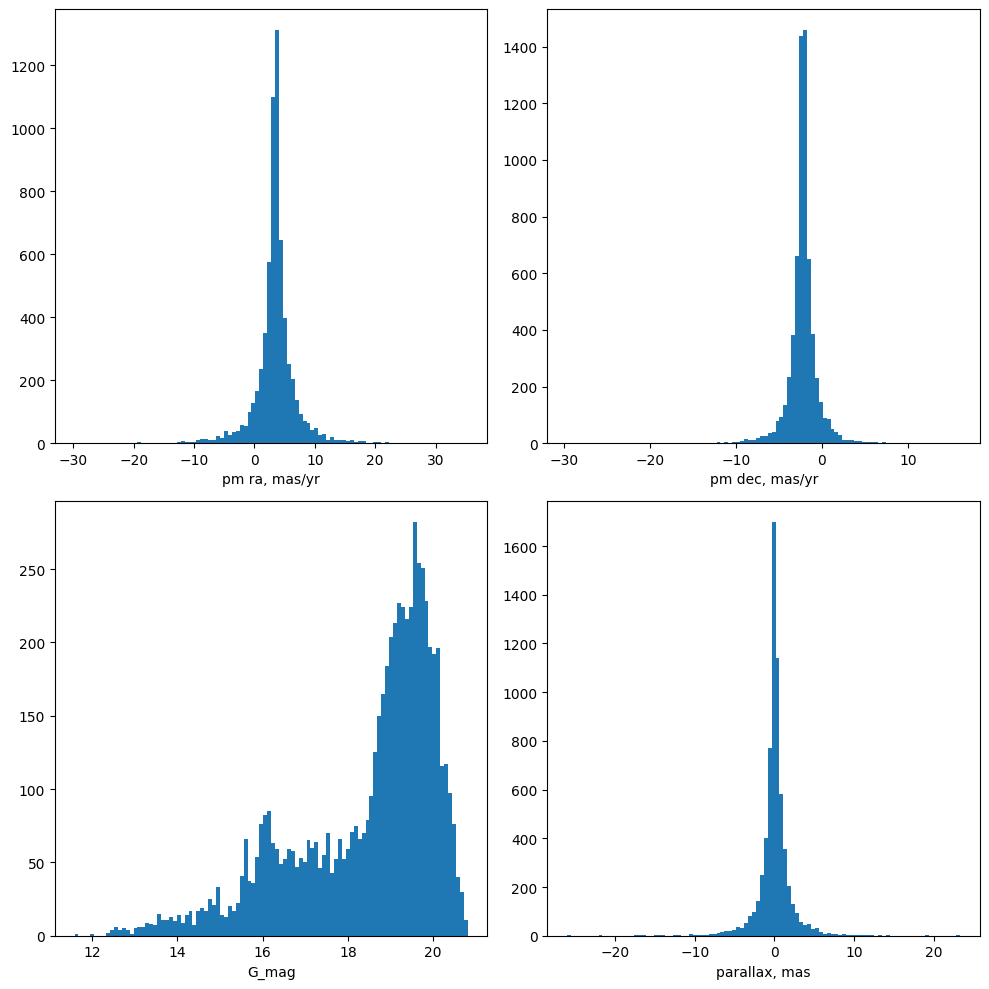

In [20]:
n_bins = 100

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=False, tight_layout=True)
axs[0][0].hist(gaia_table['pmra'], bins=n_bins, label='pm ra')
axs[0][0].set_xlabel('pm ra, mas/yr')

axs[0][1].hist(gaia_table['pmdec'], bins=n_bins, label='pm dec')
axs[0][1].set_xlabel('pm dec, mas/yr')

axs[1][0].hist(gaia_table['phot_g_mean_mag'], bins=n_bins, label='G mag')
axs[1][0].set_xlabel('G_mag')

axs[1][1].hist(gaia_table['parallax'], bins=n_bins, label='parallax')
axs[1][1].set_xlabel('parallax, mas')

plt.show()

In [21]:
from astroquery.skyview import SkyView
skyv = SkyView()
hduls = skyv.get_image_list(position="Sirius", radius=5*u.arcmin,
                        survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'])
print(hduls)

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv65487006557_1.fits', 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv65487006557_2.fits', 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv65487006557_3.fits', 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv65487006557_4.fits']


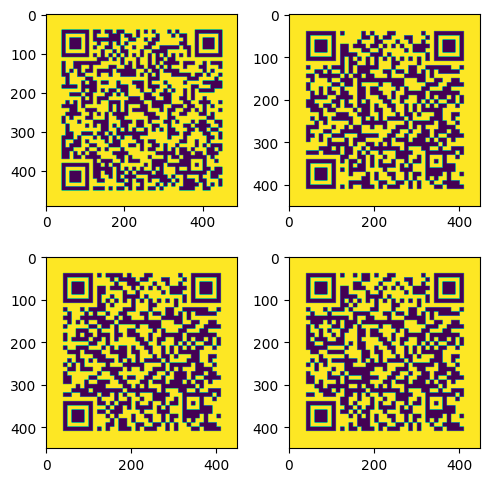

In [43]:
import qrcode
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

for i in range(len(hduls)):
    img = qrcode.make(hduls[i])
    img.save(f"W{i+1} code.png")
img = qrcode.make('https://www.youtube.com/watch?v=dQw4w9WgXcQ&pp=ygUXbmV2ZXIgZ29ubmEgZ2l2ZSB5b3UgdXA%3D')
img.save("W1 code.png")

img1 = mpimg.imread("W1 code.png")
img2 = mpimg.imread("W2 code.png")
img3 = mpimg.imread("W3 code.png")
img4 = mpimg.imread("W4 code.png")

fix, ax = plt.subplots(2, 2, figsize=(5, 5), sharey=False, tight_layout=True)    
ax[0][0].imshow(img1)
ax[0][1].imshow(img2)
ax[1][0].imshow(img3)
ax[1][1].imshow(img4)

In [49]:
hduls = skyv.get_images(position="Vega", radius=3*u.arcmin,
                        survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'])
for _ in range(len(hduls)):
    hduls[_].writeto(f"W{_+1} image.fits")

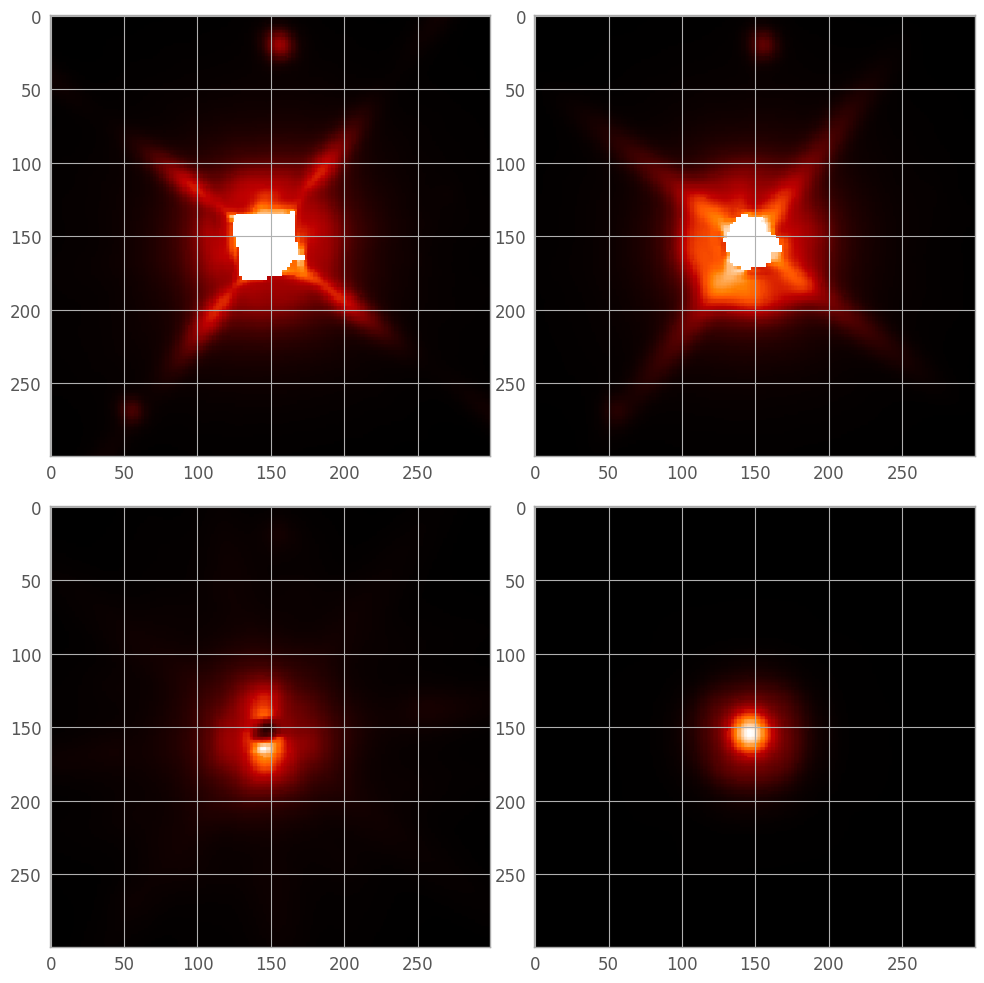

In [56]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)
image_file = []
image_data = []
for i in range(4):
    image_file.append(get_pkg_data_filename(f'W{i+1} image.fits'))
    image_data.append(fits.getdata(image_file[i], ext=0))
fix, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=False, tight_layout=True)    
ax[0][0].imshow(image_data[0])
ax[0][1].imshow(image_data[1])
ax[1][0].imshow(image_data[2])
ax[1][1].imshow(image_data[3])


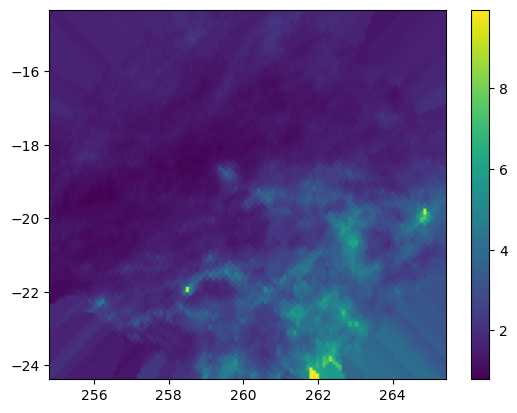

6.870972823634812 arcmin


In [13]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
%matplotlib inline
import numpy as np
from astropy_healpix import HEALPix as hp
from scipy.interpolate import griddata

def nside_to_pixel_area(nside):
    nside = np.asanyarray(nside, dtype=np.int64)
    npix = 12 * nside * nside
    pixel_area = 4 * np.pi / npix * u.sr
    return pixel_area
    
def nside_to_pixel_resolution(nside):
    nside = np.asanyarray(nside, dtype=np.int64)
    return (nside_to_pixel_area(nside) ** 0.5).to(u.arcmin)

data = np.load('I_355_tgextmap.npz')
HPId = data['HPId']
A0 = data['A0']
level = 9

ra = 260.10740722*u.deg
dec = -19.3523078*u.deg
coord = SkyCoord(ra, dec, frame='icrs')

hp = hp(nside=2**level, order='nested', frame='icrs')
search=hp.cone_search_skycoord(coord, radius=5 * u.deg)
ext = A0[np.isin(HPId, search)]
common = HPId[np.isin(HPId, search)]
cd = hp.healpix_to_skycoord(common)

ra = np.unique(cd.ra.value)
dec = np.unique(cd.dec.value)
X, Y = np.meshgrid(ra, dec)
beta = griddata(np.transpose(np.array([cd.ra.value, cd.dec.value])), np.array(ext), (X, Y), method='nearest')
im = plt.imshow(beta, cmap=plt.cm.viridis, aspect='auto', extent=[X.min(), X.max(), Y.min(), Y.max()],
                origin='lower')
plt.colorbar(im)
plt.show()

f=nside_to_pixel_resolution(2**level)
print(f)
